In [23]:
import pandas as pd
import numpy as np
import random

# File operations
from copy import deepcopy
import glob
import os
from pathlib import Path

# Stats
from scipy.spatial.distance import cdist
from scipy.stats import spearmanr, wilcoxon, mannwhitneyu, zscore
import statsmodels.stats.multitest

# Neuromaps
import neuromaps
from neuromaps.parcellate import Parcellater
from neuromaps import datasets, images, nulls, resampling, stats
from nibabel import freesurfer as fs
import nibabel as nib
from neuromaps.datasets import fetch_annotation, fetch_fslr
from enigmatoolbox.datasets import load_sc, load_fc, load_fc_as_one

# Set seed to 127
random.seed(127)

# Add connectome workbench to path
os.environ['PATH'] = os.environ['PATH'] + ':/Applications/workbench/bin_macosx64'

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [24]:
%%R 

suppressPackageStartupMessages({
    library(broom)
    library(circlize)
    library(ComplexHeatmap)
    library(cowplot)
    library(dendextend)
    library(FactoMineR)
    library(GGally)
    library(ggseg)
    library(glue)
    library(grid)
    library(patchwork)
    library(see)
    library(tidyverse)
})

# Set cowplot theme
theme_set(theme_cowplot())

In [30]:
data_path = "/Users/abry4213/github/Homotopic_FC/data/"

#### GROUP-AVERAGED FUNCTIONAL CONNECTOME FROM ENIGMA #### 
# Load cortico-cortical functional connectivity data
fc_ctx, fc_ctx_labels, _, _ = load_fc(parcellation='schaefer_400')

HCP_ctx_avg_homotopic_FC_schaefer400 = (pd.DataFrame(fc_ctx, columns=fc_ctx_labels)
                      .assign(Brain_Region_From = fc_ctx_labels)
                      .melt(id_vars=["Brain_Region_From"], 
                             var_name="Brain_Region_To", 
                             value_name="Mean_Pearson_R")
                      .assign(Hemisphere_From = lambda x: np.where(x["Brain_Region_From"].str.contains("_LH_"), "Left", "Right"),
                              Hemisphere_To = lambda x: np.where(x["Brain_Region_To"].str.contains("_LH_"), "Left", "Right"),
                              # Remove 7Networks_LH_ and 7Networks_RH_ from Brain_Region_From
                            Base_Region_From = lambda x: x["Brain_Region_From"].str.replace("7Networks_LH_", "").str.replace("7Networks_RH_", ""),
                            Base_Region_To = lambda x: x["Brain_Region_To"].str.replace("7Networks_LH_", "").str.replace("7Networks_RH_", ""))
                      .query("Hemisphere_From != Hemisphere_To & Base_Region_From == Base_Region_To")
                      .groupby(['Base_Region_From'])['Mean_Pearson_R']
                      .mean()
                      .reset_index()
                      .rename(columns={"Base_Region_From": "Base_Region", 
                                      "Mean_Pearson_R": "Mean_Homotopic_FC"})
)

In [31]:
HCP_ctx_avg_homotopic_FC_schaefer400.head()

,Base_Region,Mean_Homotopic_FC
0,Cont_Cing_1,0.064175
1,Cont_Cing_2,0.076572
2,Cont_PFCl_1,0.159350
3,Cont_PFCl_2,0.243530
4,Cont_PFCl_3,0.343680


In [38]:
core_thalamus_gradient = pd.read_csv(f"{data_path}/core_grad.csv", header=None, names=["Core"])
matrix_thalamus_gradient = pd.read_csv(f"{data_path}/matrix_grad.csv", header=None, names=["Matrix"])

core_matrix_thalamus_df = (pd.concat([core_thalamus_gradient, matrix_thalamus_gradient], axis=1)
                           .assign(Brain_Region = fc_ctx_labels)
                           .assign(Base_Region = lambda x: x["Brain_Region"].str.replace("7Networks_LH_", "").str.replace("7Networks_RH_", ""))
                           .groupby(['Base_Region'])[['Core', 'Matrix']]
                            .mean()
                            .reset_index()
)

all_HoFC_thalamus_grad_df = (pd.merge(HCP_ctx_avg_homotopic_FC_schaefer400, core_matrix_thalamus_df, on="Base_Region", how="left"))

all_HoFC_thalamus_grad_df.head()

,Base_Region,Mean_Homotopic_FC,Core,Matrix
0,Cont_Cing_1,0.064175,0.546640,0.453360
1,Cont_Cing_2,0.076572,0.364822,0.635178
2,Cont_PFCl_1,0.159350,0.476285,0.523715
3,Cont_PFCl_2,0.243530,0.397233,0.602767
4,Cont_PFCl_3,0.343680,0.406719,0.593281


`geom_smooth()` using formula = 'y ~ x'


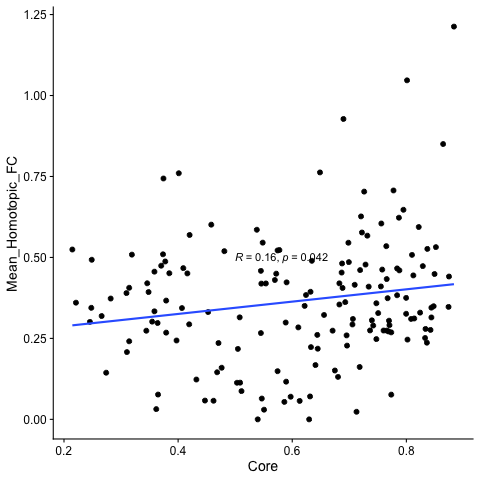

In [40]:
%%R -i all_HoFC_thalamus_grad_df

all_HoFC_thalamus_grad_df %>%
    ggplot(aes(x = Core, y = Mean_Homotopic_FC)) +
    geom_point(size = 2) +
    geom_smooth(method = "lm", se = FALSE) +
    ggpubr::stat_cor(method = "spearman", label.x = 0.5, label.y = 0.5) 